<a href="https://colab.research.google.com/github/KirillVidov/Vidov_Praktik/blob/main/%D0%92%D0%B8%D0%B4%D0%BE%D0%B2_%D0%97%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
path = kagglehub.dataset_download("alfathterry/bbc-full-text-document-classification")
print("Path to dataset files:", path)

100%|██████████| 1.84M/1.84M [00:00<00:00, 90.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/alfathterry/bbc-full-text-document-classification/versions/1


In [3]:
import pandas as pd, glob, os, numpy as np

candidates = sorted(glob.glob(os.path.join(path, "*.csv")))
assert candidates, "No CSV files found."
DATASET_PATH = candidates[0]
df = pd.read_csv(DATASET_PATH)

TEXT_COL = None; LABEL_COL = None
lc = {c.lower(): c for c in df.columns}

for k in ["text","article","content","body","news","document","headline","review","message","description"]:
    if k in lc: TEXT_COL = lc[k]; break

for k in ["category","label","class","topic","section","subject","tags","sentiment"]:
    if k in lc and lc[k] != TEXT_COL: LABEL_COL = lc[k]; break

if TEXT_COL is None:
    obj = [c for c in df.columns if df[c].dtype == "object"]
    if obj:
        L = {c: df[c].astype(str).str.len().mean() for c in obj}
        TEXT_COL = max(L, key=L.get)

if LABEL_COL is None:
    cand = [c for c in df.columns if c != TEXT_COL and df[c].nunique() <= 50]
    if cand:
        LABEL_COL = min(cand, key=lambda c: df[c].nunique())

assert TEXT_COL is not None and LABEL_COL is not None, f"Set TEXT_COL/LABEL_COL manually. Columns: {list(df.columns)}"
df = df[[TEXT_COL, LABEL_COL]].dropna()
print(DATASET_PATH, TEXT_COL, LABEL_COL, df.shape)
df.head(3)

/root/.cache/kagglehub/datasets/alfathterry/bbc-full-text-document-classification/versions/1/bbc_data.csv data labels (2225, 2)


,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

LIGHT_MODE = True
MAX_SAMPLES = 5000
MAX_FEATURES = 50000
NGRAMS = (1,2)

if LIGHT_MODE and len(df) > MAX_SAMPLES:
    df = df.groupby(LABEL_COL, group_keys=False).apply(lambda x: x.sample(min(len(x), max(1, MAX_SAMPLES // df[LABEL_COL].nunique())), random_state=42)).reset_index(drop=True)
print('Using samples:', len(df))

X_train, X_valid, y_train, y_valid = train_test_split(
    df[TEXT_COL], df[LABEL_COL], test_size=0.2, random_state=42, stratify=df[LABEL_COL]
)

Using samples: 2225


In [5]:
df = pd.read_csv(DATASET_PATH)

In [6]:
df = df[[TEXT_COL, LABEL_COL]].dropna()
vc = df[LABEL_COL].value_counts()
keep_labels = vc[vc >= 50].index
df = df[df[LABEL_COL].isin(keep_labels)].reset_index(drop=True)
print('Классов после фильтра:', df[LABEL_COL].nunique())
df.head(3)

Классов после фильтра: 5


,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
    df[TEXT_COL], df[LABEL_COL], test_size=0.2, random_state=42, stratify=df[LABEL_COL]
)
len(X_train), len(X_valid)

(1780, 445)

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
from joblib import dump
import os

USE_LINEAR_SVC = True

model = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=NGRAMS, max_features=MAX_FEATURES, min_df=2)),
    ('clf', LinearSVC() if USE_LINEAR_SVC else LogisticRegression(max_iter=200, n_jobs=-1, solver='saga'))
])

model.fit(X_train, y_train)
pred = model.predict(X_valid)
acc = accuracy_score(y_valid, pred)
f1 = f1_score(y_valid, pred, average='macro')
print('TFIDF+{} -> acc:'.format('LinearSVC' if USE_LINEAR_SVC else 'LR'), acc, 'macroF1:', f1)
print(classification_report(y_valid, pred))

os.makedirs("models", exist_ok=True)
dump(model, "models/tfidf_linear.joblib")

TFIDF+LinearSVC -> acc: 0.9865168539325843 macroF1: 0.9860432447811089
               precision    recall  f1-score   support

     business       0.97      0.99      0.98       102
entertainment       0.97      1.00      0.99        77
     politics       0.99      0.99      0.99        84
        sport       1.00      1.00      1.00       102
         tech       1.00      0.95      0.97        80

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99       445
 weighted avg       0.99      0.99      0.99       445



['models/tfidf_linear.joblib']

In [15]:
RUN_BERT = True

import os, numpy as np
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "disabled"

from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

MODEL_NAME = "distilbert-base-uncased"  # for even faster runs: "prajjwal1/bert-tiny"

le_bert = LabelEncoder()
y_train_ids = le_bert.fit_transform(y_train)
y_valid_ids = le_bert.transform(y_valid)
num_labels = len(le_bert.classes_)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tok(batch):
    return tokenizer(batch[TEXT_COL], truncation=True, padding='max_length', max_length=128)

ds_train = Dataset.from_dict({TEXT_COL: list(X_train), 'labels': y_train_ids}).map(tok, batched=True).remove_columns([TEXT_COL])
ds_valid = Dataset.from_dict({TEXT_COL: list(X_valid), 'labels': y_valid_ids}).map(tok, batched=True).remove_columns([TEXT_COL])

bert_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_labels)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    from sklearn.metrics import accuracy_score, f1_score
    return {'accuracy': accuracy_score(labels, preds), 'macro_f1': f1_score(labels, preds, average='macro')}

args = TrainingArguments(
    output_dir="models/bert",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    logging_steps=100
)

trainer = Trainer(model=bert_model, args=args, train_dataset=ds_train, eval_dataset=ds_valid, compute_metrics=compute_metrics)
trainer.train()
metrics = trainer.evaluate()
print(metrics)

Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

Map:   0%|          | 0/445 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
100,0.897500
200,0.212100


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.12326857447624207, 'eval_accuracy': 0.9775280898876404, 'eval_macro_f1': 0.9775055539457161, 'eval_runtime': 81.4042, 'eval_samples_per_second': 5.467, 'eval_steps_per_second': 0.688, 'epoch': 1.0}


In [19]:
import numpy as np
from joblib import load
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

def get_classic():
    try:
        return load("models/tfidf_linear.joblib")
    except:
        vec = TfidfVectorizer(ngram_range=NGRAMS, max_features=MAX_FEATURES, min_df=2)
        clf = LinearSVC() if USE_LINEAR_SVC else LogisticRegression(max_iter=200, n_jobs=-1, solver='saga')
        m = Pipeline([('tfidf', vec), ('clf', clf)])
        m.fit(X_train, y_train)
        return m

classic = get_classic()
clf = CalibratedClassifierCV(classic, method='sigmoid', cv=3) if USE_LINEAR_SVC else classic
if USE_LINEAR_SVC:
    clf.fit(X_train, y_train)

proba_lr = clf.predict_proba(X_valid)
probas = [proba_lr]

if 'RUN_BERT' in globals() and RUN_BERT and 'bert_model' in globals():
    import torch
    from transformers import AutoTokenizer
    tok = AutoTokenizer.from_pretrained(MODEL_NAME)
    def bert_proba(texts):
        bert_model.eval()
        out = []
        for t in texts:
            enc = tok(t, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
            with torch.no_grad():
                p = torch.softmax(bert_model(**enc).logits, dim=-1).cpu().numpy()[0]
            out.append(p)
        return np.array(out)
    probas.append(bert_proba(X_valid.tolist()))

X_meta = np.hstack(probas)
meta = LogisticRegression(max_iter=200)
meta.fit(X_meta, y_valid)
pred_meta = meta.predict(X_meta)
print('STACK acc:', accuracy_score(y_valid, pred_meta), 'macroF1:', f1_score(y_valid, pred_meta, average='macro'))

STACK acc: 0.9887640449438202 macroF1: 0.9889190306882945


In [21]:
import os, json, time

os.makedirs("reports", exist_ok=True)
report = {
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "classes": sorted(df[LABEL_COL].unique().tolist()),
    "samples_total": int(df.shape[0])
}
out_path = "reports/summary.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(report, f, ensure_ascii=False, indent=2)
print("Saved:", out_path)

Saved: reports/summary.json


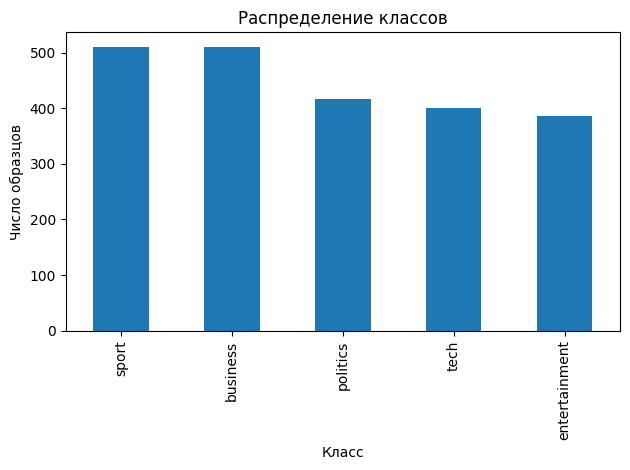

Saved: reports/class_distribution.png


In [23]:
import os
import matplotlib.pyplot as plt

os.makedirs("reports", exist_ok=True)
ax = df[LABEL_COL].value_counts().sort_values(ascending=False).plot(kind="bar")
ax.set_title("Распределение классов")
ax.set_xlabel("Класс")
ax.set_ylabel("Число образцов")
plt.tight_layout()
plt.savefig("reports/class_distribution.png", dpi=150)
plt.show()
print("Saved: reports/class_distribution.png")

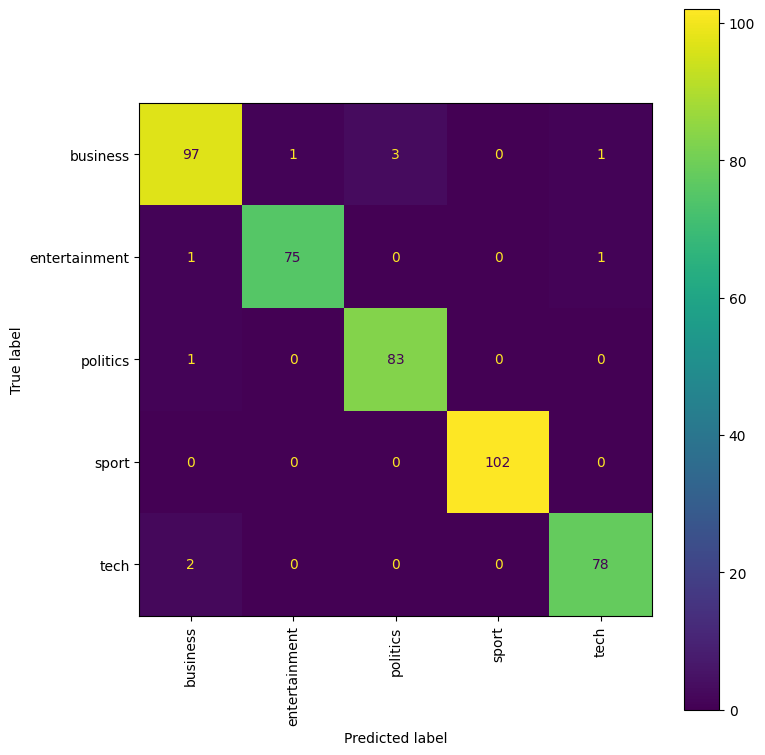

               precision    recall  f1-score   support

     business       0.96      0.95      0.96       102
entertainment       0.99      0.97      0.98        77
     politics       0.97      0.99      0.98        84
        sport       1.00      1.00      1.00       102
         tech       0.97      0.97      0.97        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445

Saved: reports/confusion_matrix.png


In [27]:
import os, numpy as np, torch, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

os.makedirs("reports", exist_ok=True)

def predict_sklearn():
    return model.predict(X_valid)

def predict_bert():
    bert_model.eval()
    out = []
    for t in X_valid.tolist():
        enc = tokenizer(t, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        with torch.no_grad():
            p = torch.argmax(bert_model(**enc).logits, dim=-1).cpu().numpy()[0]
        out.append(le_bert.inverse_transform([p])[0])
    return np.array(out)

try:
    pred = predict_sklearn()
except Exception:
    pred = predict_bert()

labels = sorted(y_valid.unique())
cm = confusion_matrix(y_valid, pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=90)
plt.tight_layout()
plt.savefig("reports/confusion_matrix.png", dpi=150)
plt.show()

print(classification_report(y_valid, pred))
print("Saved: reports/confusion_matrix.png")

Saved: reports/benchmark_speed.csv


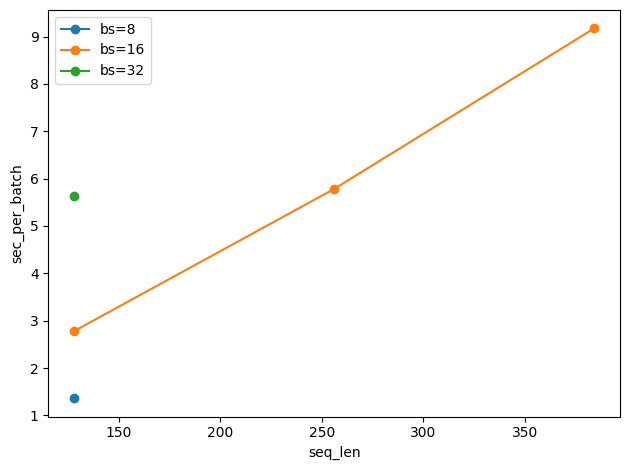

Saved: reports/benchmark_speed.png


In [29]:
import os, time, numpy as np, pandas as pd
os.makedirs("reports", exist_ok=True)

results = []

if 'bert_model' in globals():
    import torch
    from transformers import AutoTokenizer
    tok = AutoTokenizer.from_pretrained(MODEL_NAME)
    def time_batch(bs, sl, steps=10):
        texts = [" ".join(["word"]*sl)]*bs
        enc = tok(texts, truncation=True, padding='max_length', max_length=sl, return_tensors='pt')
        with torch.no_grad():
            _ = bert_model(**enc)
        t0 = time.time()
        with torch.no_grad():
            for _ in range(steps):
                _ = bert_model(**enc)
        return (time.time()-t0)/steps
    for bs, sl in [(8,128),(16,128),(32,128),(16,256),(16,384)]:
        try:
            dt = time_batch(bs, sl)
        except Exception:
            dt = None
        results.append({"model":"bert","batch_size":bs,"seq_len":sl,"sec_per_batch":dt})
else:
    from time import perf_counter
    sample = X_valid.sample(min(500, len(X_valid)), random_state=42).tolist()
    for bs in [8,16,32,64]:
        texts = (sample*(bs//len(sample)+1))[:bs]
        t0 = perf_counter()
        _ = model.predict(texts)
        dt = perf_counter() - t0
        results.append({"model":"classic","batch_size":bs,"seq_len":None,"sec_per_batch":dt})

bench_df = pd.DataFrame(results)
bench_df.to_csv("reports/benchmark_speed.csv", index=False)
print("Saved: reports/benchmark_speed.csv")

import matplotlib.pyplot as plt

if (bench_df["model"]=="bert").any():
    sub = bench_df[bench_df["model"]=="bert"]
    if not sub.empty:
        plt.figure()
        for bs in sorted(sub["batch_size"].unique()):
            s = sub[sub["batch_size"]==bs].sort_values("seq_len")
            plt.plot(s["seq_len"], s["sec_per_batch"], marker="o", label=f"bs={bs}")
        plt.legend()
        plt.xlabel("seq_len"); plt.ylabel("sec_per_batch")
        plt.tight_layout()
        plt.savefig("reports/benchmark_speed.png", dpi=150)
        plt.show()
else:
    sub = bench_df[bench_df["model"]=="classic"].sort_values("batch_size")
    if not sub.empty:
        plt.figure()
        plt.plot(sub["batch_size"], sub["sec_per_batch"], marker="o")
        plt.xlabel("batch_size"); plt.ylabel("sec_per_batch")
        plt.tight_layout()
        plt.savefig("reports/benchmark_speed.png", dpi=150)
        plt.show()

print("Saved: reports/benchmark_speed.png")